In [1]:
import numpy as np
import pandas as pd
import scprep
import multiscale_phate as mp
import matplotlib.pyplot as plt
import os, re, time

In [2]:
data_dir = '/Users/6j9/projects/human_mouse_skin/data/count_matrices/ko'
out_dir = '/Users/6j9/projects/human_mouse_skin/plots/multi_phate'

sample_dirs = [os.path.join(data_dir, path) for path in os.listdir(data_dir)]
sample_dirs.sort()

In [3]:
for i, sample_dir in enumerate(sample_dirs):
    print(i)
    if i == 0:
        combined_mtx = scprep.io.load_10X(sample_dir, gene_labels='symbol')
        combined_mtx.index.name = None
    else:
        mtx = scprep.io.load_10X(sample_dir, gene_labels='symbol')
        mtx.index.name = None
        combined_mtx = pd.concat([combined_mtx, mtx])

mtx = combined_mtx

0
1
2
3
4


In [4]:
mp_op = mp.Multiscale_PHATE(random_state=8)
mtx = scprep.filter.filter_rare_genes(mtx)
mtx_norm, libsize = scprep.normalize.library_size_normalize(mtx, return_library_size=True)
mtx_sqrt = np.sqrt(mtx_norm)
levels = mp_op.fit(mtx_sqrt)

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 21.85 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 34.24 seconds.
  Setting epsilon to 2.5771
  Setting merge threshold to 0.0031
  Calculating condensation...
  Calculated condensation in 31.66 seconds.
Calculated Multiscale PHATE tree in 88.94 seconds.
Computing gradient...
Identifying salient levels of resolution...


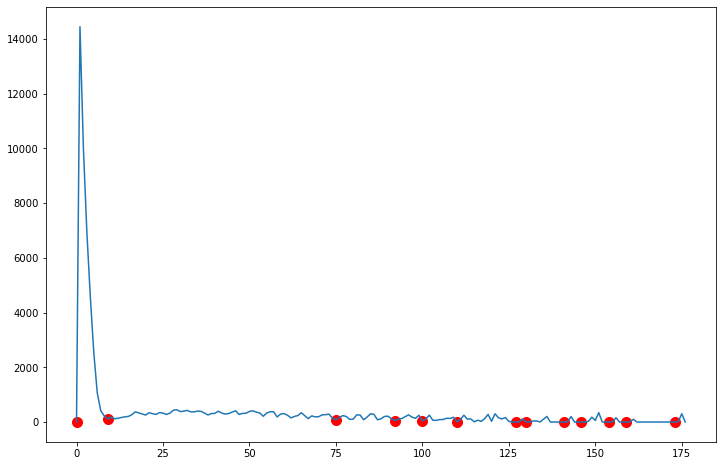

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(mp_op.gradient)
ax.scatter(levels, mp_op.gradient[levels], c = 'r', s=100)
out_path = os.path.join(out_dir, 'levels.png')
#plt.savefig(out_path, dpi=300)

Calculating base visualization...
Calculating tree...
Calculated tree in 0.73 seconds.


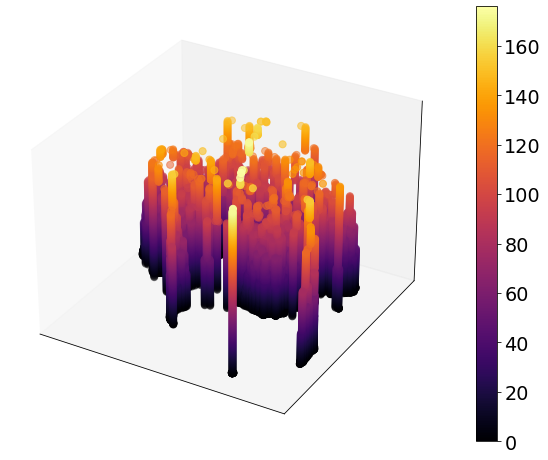

In [7]:
tree = mp_op.build_tree()
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw=dict(projection='3d'))
scprep.plot.scatter3d(tree, ax=ax, c = tree[:,2], s= 50, fontsize=16, ticks=False)
out_path = os.path.join(out_dir, 'tree.png')
#plt.savefig(out_path, dpi=300)

In [8]:
levels

[0, 9, 75, 92, 100, 110, 127, 130, 141, 146, 154, 159, 173]

In [8]:
len(levels)

13

In [9]:
for level in levels:
    clusters = mp_op.get_tree_clusters(level)
    print(len(np.unique(clusters)))

10547
2217
195
96
71
47
16
16
10
8
4
3
2


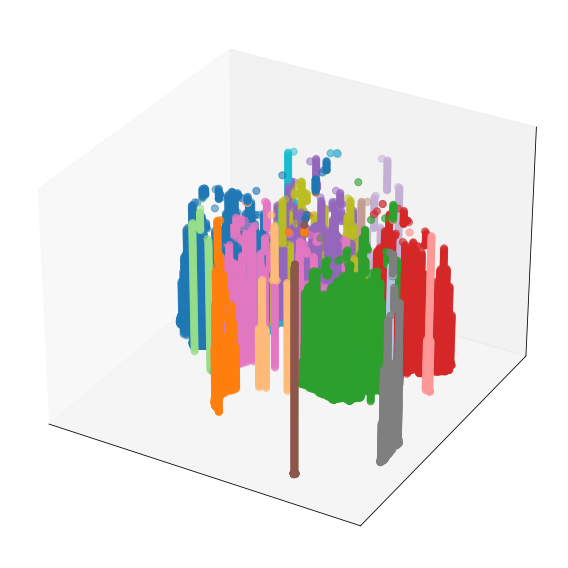

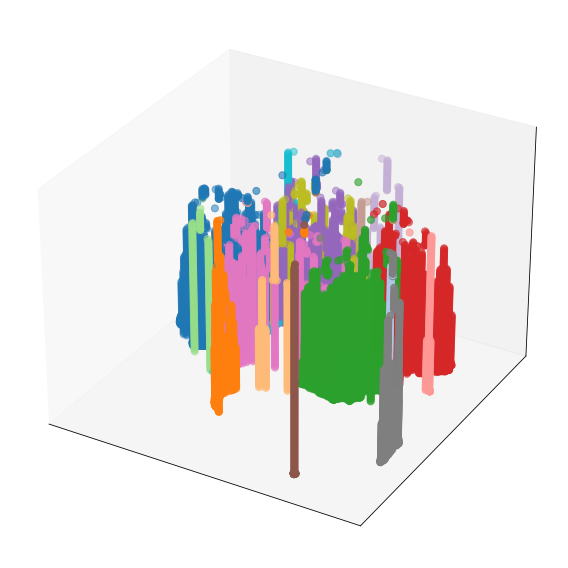

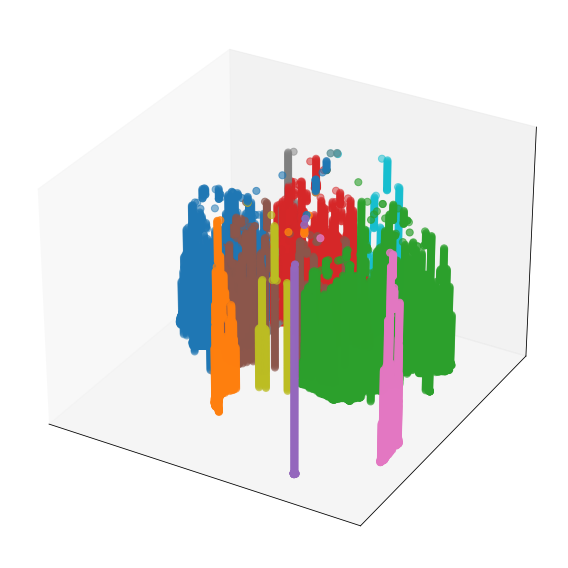

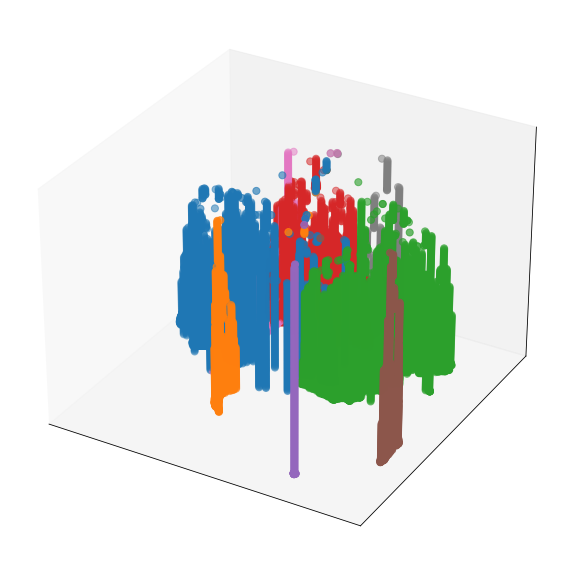

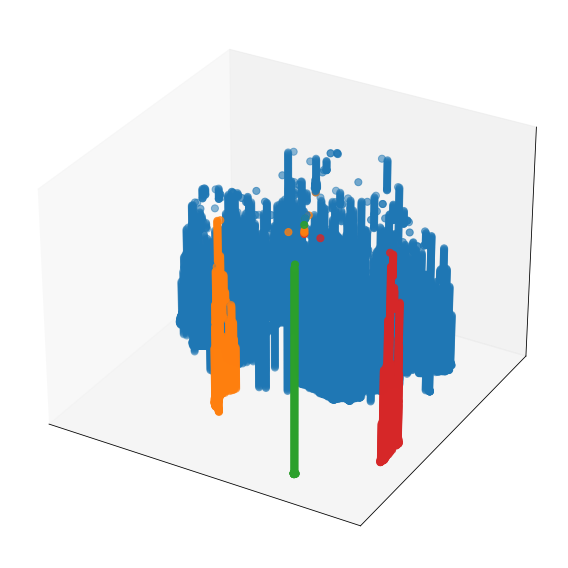

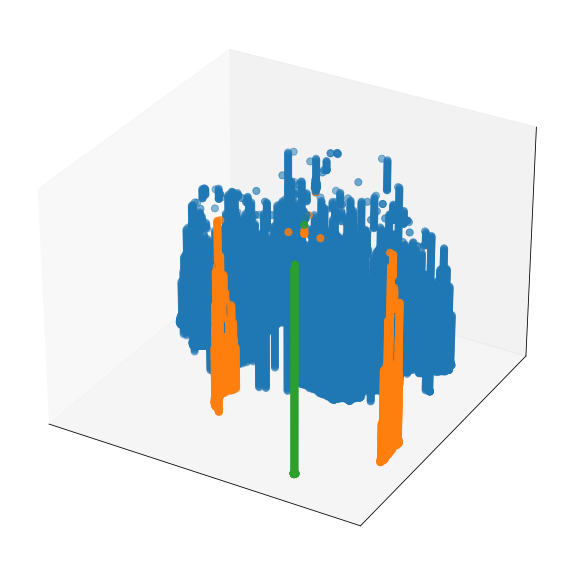

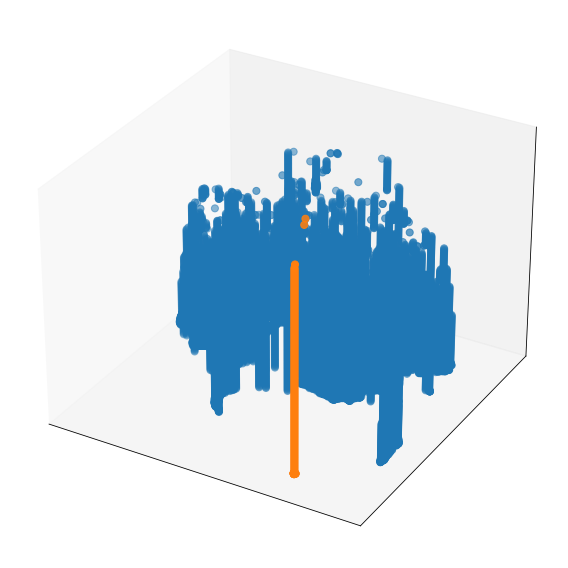

In [10]:
for i, level in enumerate(levels):
    if i < 6: continue
    tree_clusters = mp_op.get_tree_clusters(level)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw=dict(projection='3d'))
    scprep.plot.scatter3d(tree, ax=ax, c = tree_clusters, s= 50, fontsize=16, ticks=False, discrete=True,
                          legend_loc=(1, 1), legend_anchor=(1, 0), legend=False)
    plt.tight_layout()
    plt.show()

# Embedding

In [17]:
print(coarse_embedding.shape)
coarse_embedding

(1092, 2)


array([[-0.02379338,  0.00589098],
       [-0.00518469, -0.03915944],
       [-0.0306056 , -0.00287642],
       ...,
       [ 0.03805867,  0.01425845],
       [ 0.01813445,  0.0321924 ],
       [ 0.00980808,  0.01676919]])

In [21]:
print(len(coarse_clusters))
coarse_clusters_uniq, coarse_clusters_counts = np.unique(coarse_clusters, return_counts=True)
print(coarse_clusters_uniq)
print(coarse_clusters_counts)

1092
[   0    1    3    6   12   49   70   82 7620]
[316  20 214 289 122   1  96   8  26]


In [18]:
print(len(coarse_sizes))
coarse_sizes

2217


array([ 35,   3, 112, ...,   1,   1,   1])

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

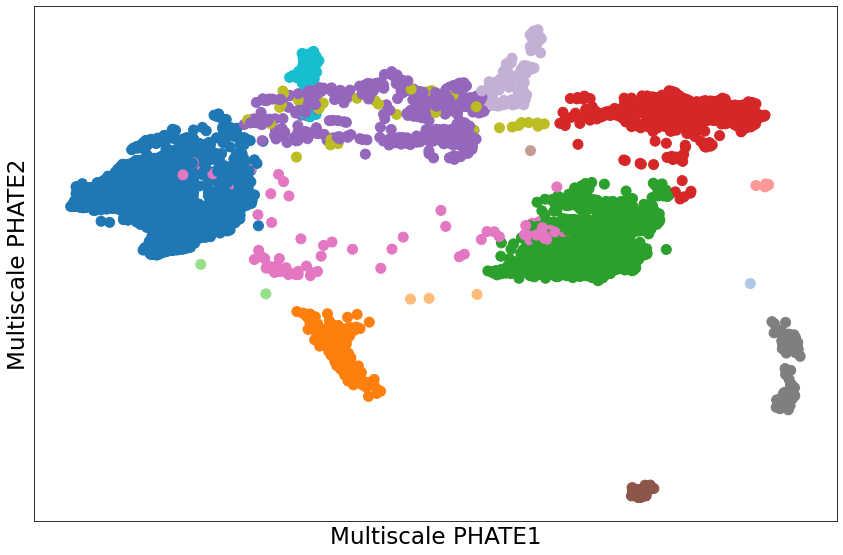

In [10]:
vis_level = 0
cluster_level = 6

coarse_embedding, coarse_clusters, coarse_sizes = mp_op.transform(visualization_level = levels[vis_level],
                                                                  cluster_level = levels[cluster_level])

scprep.plot.scatter2d(coarse_embedding, s = 100*np.sqrt(coarse_sizes), c = coarse_clusters,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(12,8), legend=False)

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

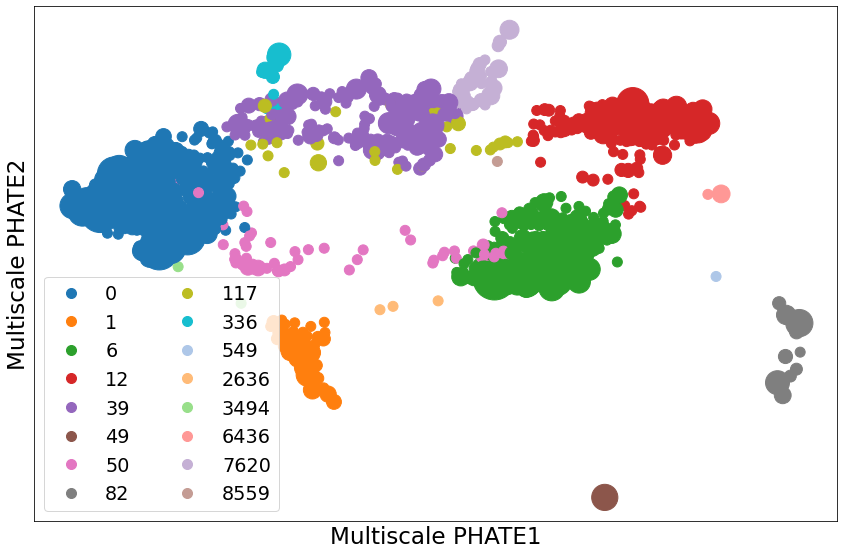

In [22]:
vis_level = 1
cluster_level = 6

coarse_embedding, coarse_clusters, coarse_sizes = mp_op.transform(visualization_level = levels[vis_level],
                                                                  cluster_level = levels[cluster_level])

scprep.plot.scatter2d(coarse_embedding, s = 100*np.sqrt(coarse_sizes), c = coarse_clusters,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(12,8), legend=False)

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

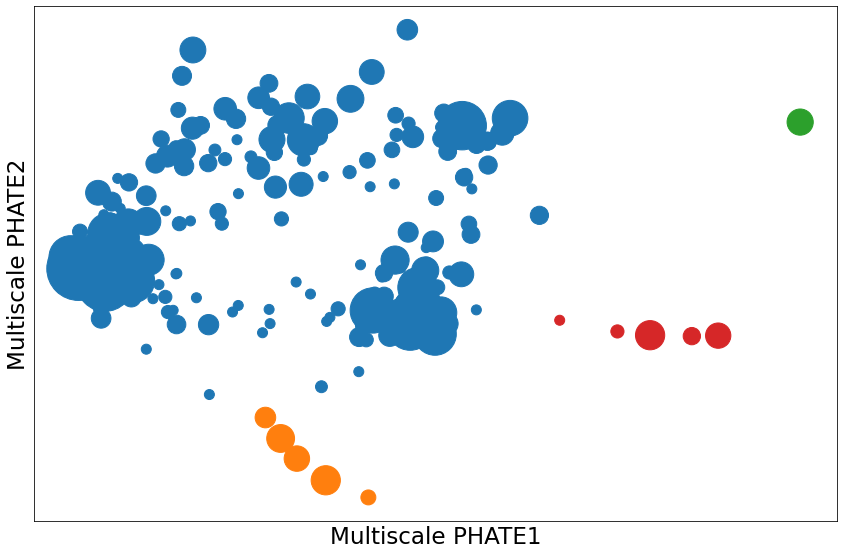

In [19]:
vis_level = 2
cluster_level = 10

coarse_embedding, coarse_clusters, coarse_sizes = mp_op.transform(visualization_level = levels[vis_level],
                                                                  cluster_level = levels[cluster_level])

scprep.plot.scatter2d(coarse_embedding, s = 100*np.sqrt(coarse_sizes), c = coarse_clusters,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(12,8), legend=False)

In [51]:
coarse_expression = pd.DataFrame()
coarse_expression['CCL11'] = mp_op.get_expression(mtx_sqrt['CCL11'].values,
                                                 visualization_level =  levels[2])
coarse_expression['CEBPB'] = mp_op.get_expression(mtx_sqrt['CEBPB'].values,
                                                 visualization_level =  levels[2])
condition = np.array([0 if i < 6332 else 1000 for i in range(mtx.shape[0])])
coarse_expression['condition'] = mp_op.get_expression(condition,
                                                      visualization_level =  levels[2])

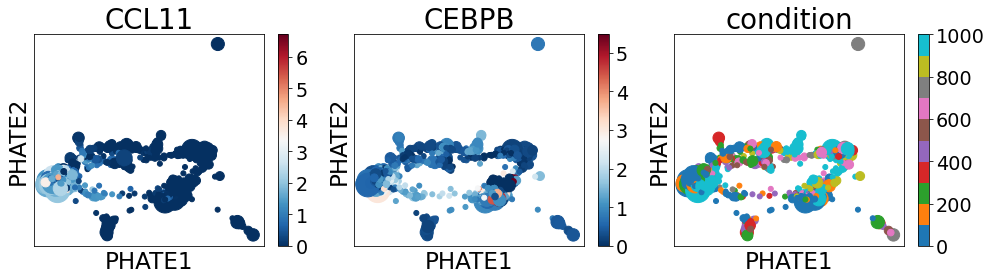

In [52]:
fig, axes = plt.subplots(1,3, figsize=(14, 4))
genes = ['CCL11', 'CEBPB', 'condition']
cmaps = ['RdBu_r', 'RdBu_r', 'tab10']

for i, ax in enumerate(axes.flatten()):
    scprep.plot.scatter2d(coarse_embedding, s = 25*np.sqrt(coarse_sizes),
                          c=coarse_expression[genes[i]], legend_anchor=(1,1), ax=ax, title=genes[i],
                          xticks=False, yticks=False, label_prefix="PHATE", fontsize=16, cmap = cmaps[i])

fig.tight_layout()

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

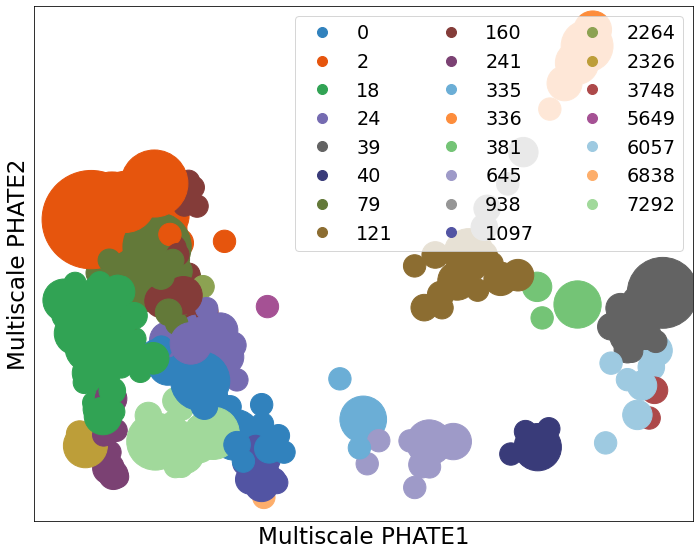

In [23]:
zoom_embedding, zoom_clusters, zoom_sizes =  mp_op.transform(visualization_level=levels[2],
                                                             cluster_level=levels[4],
                                                             coarse_cluster_level=levels[8],
                                                             coarse_cluster=0)

scprep.plot.scatter2d(zoom_embedding, s = 500*np.sqrt(zoom_sizes), c = zoom_clusters, discrete=True,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(10,8))

# Cell Types

In [55]:
acc_to_id = {'SRR14253412': '-1_86846',
             'SRR14253413': '-1_86847',
             'SRR14253414': '-1_86848',
             'SRR14253415': '-1_86849',
             'SRR14253416': '-1_92848'}

new_idx = []
for i in range(mtx_sqrt.shape[0]):
    bc, acc = re.search('([A-Z]+)\_(SRR\d+)', mtx_sqrt.index[i]).groups()
    bc = bc + acc_to_id[acc]
    new_idx.append(bc)
    
mtx_sqrt.index = new_idx

In [20]:
ct_path = '/Users/6j9/projects/mouse/data/top8_v2.tsv'
ct = pd.read_csv(ct_path, sep='\t', header=None, index_col=None)
ct.index = ct.iloc[:, 0]
ct.columns = ['bc', 'ct']
ct = ct.drop(['bc'], axis=1)
mtx_sqrt['ct'] = np.repeat('Other', mtx_sqrt.shape[0])
for i, bc in enumerate(mtx_sqrt.index):
    if bc in ct.index:
        if bc in mtx_sqrt.index:
            mtx_sqrt.loc[bc, 'ct'] = ct.loc[bc].values[0]

<ipython-input-20-bc9f91601e8a>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  mtx_sqrt['ct'] = np.repeat('Other', mtx_sqrt.shape[0])


In [21]:
vis_level = 2
cluster_level = 8

coarse_embedding, coarse_clusters, coarse_sizes = mp_op.transform(visualization_level = levels[vis_level],
                                                                  cluster_level = levels[cluster_level])
scprep.plot.scatter2d(coarse_embedding, s=100*np.sqrt(coarse_sizes), c=mtx_sqrt.loc[:, 'ct'].values,
                      fontsize=16, ticks=False, label_prefix="Multiscale PHATE", figsize=(12,8))

ValueError: Expected c of length 195 or 1. Got 10547

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

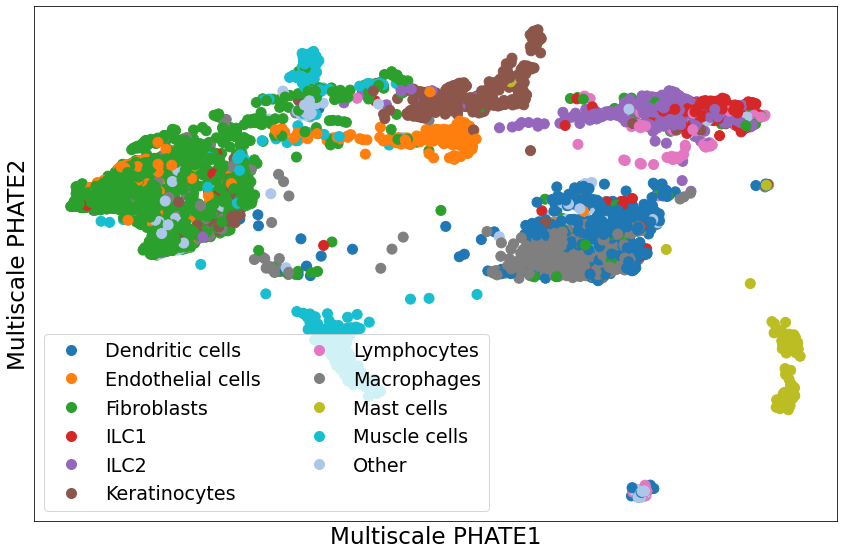

In [90]:
vis_level = 0
cluster_level = 8

coarse_embedding, coarse_clusters, coarse_sizes = mp_op.transform(visualization_level = levels[vis_level],
                                                                  cluster_level = levels[cluster_level])
scprep.plot.scatter2d(coarse_embedding, s=100*np.sqrt(coarse_sizes), c=mtx_sqrt.loc[:, 'ct'].values,
                      fontsize=16, ticks=False, label_prefix="Multiscale PHATE", figsize=(12,8))

In [101]:
condition = []
#mtx_sqrt['condition'] = np.repeat('Experimental', mtx_sqrt.shape[0])
for bc in mtx_sqrt.index:
    if re.match('[A-Z]+-1_86846', bc):
        mtx_sqrt.loc[bc, 'Experimental'] = 'WT'
    elif re.match('[A-Z]+-1_86847', bc):
        mtx_sqrt.loc[bc, 'Experimental'] = 'WT'
    else:
        mtx_sqrt.loc[bc, 'Experimental'] = 'Experimental'

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

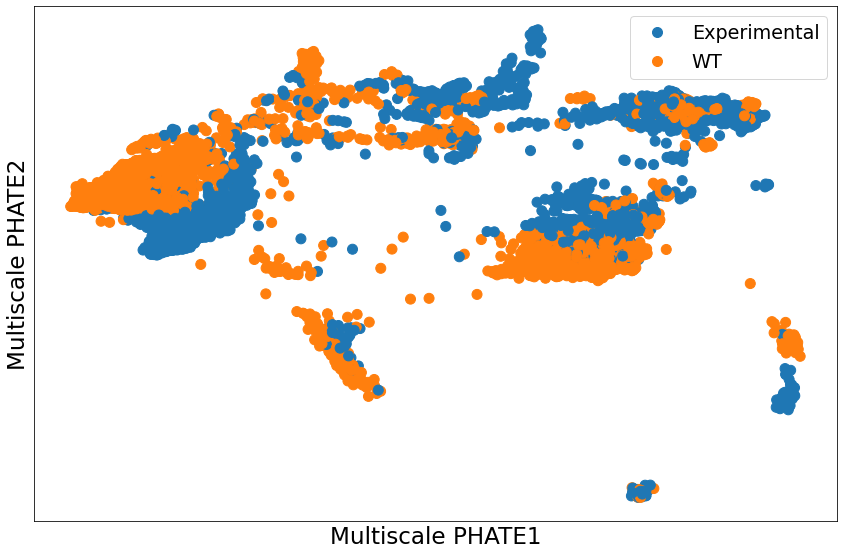

In [104]:
vis_level = 0
cluster_level = 8

coarse_embedding, coarse_clusters, coarse_sizes = mp_op.transform(visualization_level = levels[vis_level],
                                                                  cluster_level = levels[cluster_level])
scprep.plot.scatter2d(coarse_embedding, s=100*np.sqrt(coarse_sizes), c=mtx_sqrt.loc[:, 'Experimental'].values,
                      fontsize=16, ticks=False, label_prefix="Multiscale PHATE", figsize=(12,8))